# Chapter 05 - Support Vector Machines

A Support Vector Machine (SVM) is a powerful and versatile Machine Learning
model, capable of performing linear or nonlinear classification, regression, and
even outlier detection. It is one of the most popular models in Machine Learning,
and anyone interested in Machine Learning should have it in their toolbox.
SVMs are particularly well suited for classification of complex small- or
medium-sized datasets.

In [11]:
import numpy as  np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn import datasets

## Linear SVM Classification

In [7]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

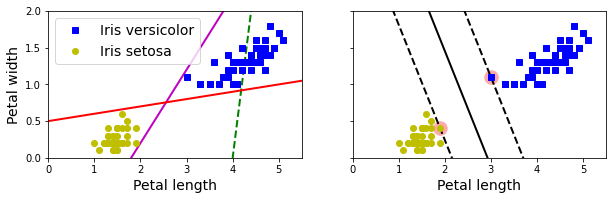

In [18]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

The idea behind the SVM is depicted in the right plot. We can draw several lines that perfectly splits the dataset. However, SVM searches for the line that is more distant from the points, ensuring that the classifier generalizes well. Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. Be warned that SVMs are very sensitive to feature scales.

### Soft Margin Classification

If we strictly impose that all instances must be off the street and on the right side,
this is called hard margin classification. There are two main issues with hard
margin classification. First, it only works if the data is linearly separable.
Second, it is sensitive to outliers. Figure 5-3 shows the iris dataset with just one
additional outlier: on the left, it is impossible to find a hard margin; on the right,
the decision boundary ends up very different from the one we saw in Figure 5-1. 

To avoid these issues, use a more flexible model. The objective is to find a good
balance between keeping the street as large as possible and limiting the margin
violations (i.e., instances that end up in the middle of the street or even on the
wrong side). This is called soft margin classification.

The hyperparameter that controls regularization in Scikit-Learn is C. If your SVM model is overfitting, you can try regularizing it by reducing C.

In [22]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [23]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [24]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/home/alexandre/anaconda3/envs/eda/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [25]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

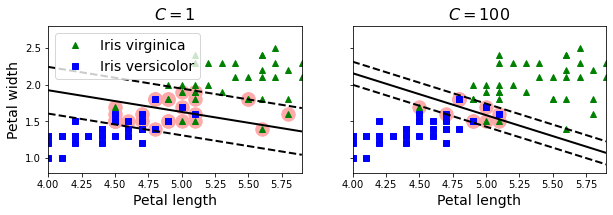

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.show()

The model with C=1 has more margin violation but it probably generalizes better.

Instead of using the LinearSVC class, we could use the SVC class with a linear
kernel. When creating the SVC model, we would write SVC(kernel="linear",
C=1). Or we could use the SGDClassifier class, with
SGDClassifier(loss="hinge", alpha=1/(m*C)). This applies regular
Stochastic Gradient Descent (see Chapter 4) to train a linear SVM classifier. It
does not converge as fast as the LinearSVC class, but it can be useful to handle
online classification tasks or huge datasets that do not fit in memory (out-of-core
training)

## Nonlinear SVM Classification

One approach to handling nonlinear datasets is to add more features, such as
polynomial features (as you did in Chapter 4); in some cases this can result in a
linearly separable dataset.

In [27]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
("poly_features", PolynomialFeatures(degree=3)),
("scaler", StandardScaler()),
("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

/home/alexandre/anaconda3/envs/eda/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

### Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all
sorts of Machine Learning algorithms (not just SVMs). That said, at a low
polynomial degree, this method cannot deal with very complex datasets, and
with a high polynomial degree it creates a huge number of features, making the
model too slow.

Fortunately, when using SVMs you can apply an almost miraculous
mathematical technique called the kernel trick (explained in a moment). The
kernel trick makes it possible to get the same result as if you had added many
polynomial features, even with very high-degree polynomials, without actually
having to add them. So there is no combinatorial explosion of the number of
features because you don’t actually add any features. This trick is implemented
by the SVC class. Let’s test it on the moons dataset:

In [31]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

The hyperparameter coef0 controls how much the model is influenced by high-degree polynomials versus low-degree polynomials. This is useful to mitigate underfitting and overfitting.

### Similarity Features

Another technique to tackle nonlinear problems is to add features computed
using a similarity function, which measures how much each instance resembles a
particular landmark. For example, let’s take the 1D dataset discussed earlier and
add two landmarks to it at x = –2 and x = 1 (see the left plot in Figure 5-8).
Next, let’s define the similarity function to be the Gaussian Radial Basis
Function (RBF) with γ = 0.3 (see Equation 5-1).

$$
\phi_{\gamma}(x, l) = \exp(-\gamma||x - l||^2)
$$

This is a bell-shaped function varying from 0 (very far away from the landmark)
to 1 (at the landmark). Now we are ready to compute the new features. For
example, let’s look at the instance x = –1: it is located at a distance of 1 from the
first landmark and 2 from the second landmark. Therefore its new features are x
= exp(–0.3 × 1 ) ≈ 0.74 and x = exp(–0.3 × 2 ) ≈ 0.30.

In [38]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]

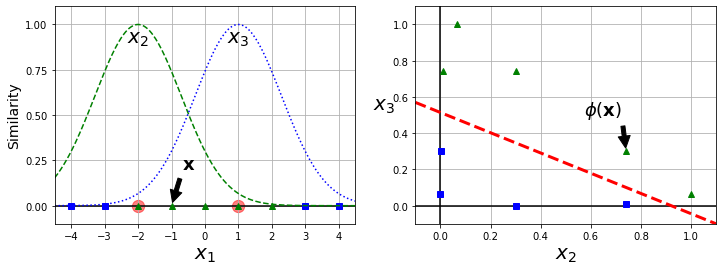

In [39]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

### Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be
useful with any Machine Learning algorithm, but it may be computationally
expensive to compute all the additional features, especially on large training sets.
Once again the kernel trick does its SVM magic, making it possible to obtain a
similar result as if you had added many similarity features. Let’s try the SVC
class with the Gaussian RBF kernel:

In [40]:
rbf_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

Increasing gamma makes the bell-shaped curve narrower. As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual
instances. Conversely, a small gamma value makes the bell-shaped curve wider:
instances have a larger range of influence, and the decision boundary ends up
smoother. So γ acts like a regularization hyperparameter: if your model is
overfitting, you should reduce it; if it is underfitting, you should increase it
(similar to the C hyperparameter).

- Tip

**With so many kernels to choose from, how can you decide which one to use? As a rule of
thumb, you should always try the linear kernel first (remember that LinearSVC is much faster
than SVC(kernel="linear")), especially if the training set is very large or if it has plenty of
features. If the training set is not too large, you should also try the Gaussian RBF kernel; it
works well in most cases. Then if you have spare time and computing power, you can
experiment with a few other kernels, using cross-validation and grid search. You’d want to
experiment like that especially if there are kernels specialized for your training set’s data
structure.**

### Computational Complexity

The **LinearSVC class is based on the liblinear library**, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features. Its training time complexity is roughly O(m × n).

The algorithm takes longer if you require very high precision. This is controlled by the tolerance hyperparameter ϵ (called tol in Scikit-Learn). In most classification tasks, the default tolerance is fine.

The **SVC class is based on the libsvm library**, which implements an algorithm that supports the kernel trick. The training time complexity is usually between O(m × n) and O(m × n). Unfortunately, this means that it gets dreadfully slow when the number of training instances gets large (e.g., hundreds of thousands of instances). This algorithm is perfect for complex small or medium-sized training sets. It scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance. Table 5-1 compares Scikit-Learn’s SVM classification classes.

## SVM Regression

As mentioned earlier, the SVM algorithm is versatile: not only does it support
linear and nonlinear classification, but it also supports linear and nonlinear
regression. To use SVMs for regression instead of classification, the trick is to
reverse the objective: instead of trying to fit the largest possible street between
two classes while limiting margin violations, SVM Regression tries to fit as
many instances as possible on the street while limiting margin violations (i.e.,
instances off the street). The width of the street is controlled by a
hyperparameter, ϵ. Figure 5-10 shows two linear SVM Regression models
trained on some random linear data, one with a large margin (ϵ = 1.5) and the
other with a small margin (ϵ = 0.5).

In [41]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [42]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [43]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

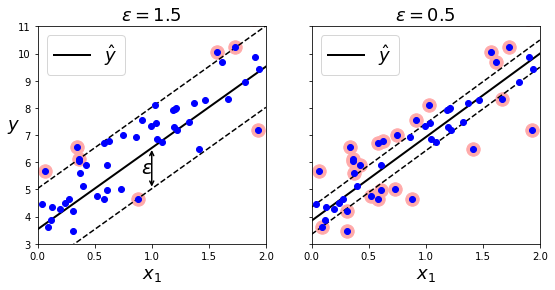

In [44]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

Adding more training instances within the margin does not affect the model’s
predictions; thus, the model is said to be ϵ-insensitive.

You can use Scikit-Learn’s LinearSVR class to perform linear SVM Regression.
The following code produces the model represented on the left in Figure 5-10
(the training data should be scaled and centered first):

In [45]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5)

To tackle nonlinear regression tasks, you can use a kernelized SVM model.

The following code uses Scikit-Learn’s SVR class (which supports the kernel
trick).

In [46]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

The SVR class is the regression equivalent of the SVC class, and the LinearSVR
class is the regression equivalent of the LinearSVC class. The LinearSVR class
scales linearly with the size of the training set (just like the LinearSVC class),
while the SVR class gets much too slow when the training set grows large (just
like the SVC class).